In [1]:
from config.config import TRAIN_START_DATE,TRAIN_END_DATE,VALID_START_DATE,VALID_END_DATE,TRADE_START_DATE, TRADE_END_DATE 
# DATE_SPLIT = [TRAIN_START_DATE,TRAIN_END_DATE,VALID_START_DATE,VALID_END_DATE,TRADE_START_DATE, TRADE_END_DATE]
from get_train_valid_trade_data import get_train_valid_trade_data
tech_list = ['open', 'high', 'low', 'close', 'volume', 'macd', 'rsi_30', 'cci_30', 'dx_30']
# tech_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_list = ['date','tic']+tech_list
df, train, valid, trade = get_train_valid_trade_data(feature_list, TRAIN_START_DATE,TRAIN_END_DATE,
                                                     VALID_START_DATE,VALID_END_DATE,TRADE_START_DATE, TRADE_END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [2]:
df.to_csv('data/df.csv')
train.to_csv('data/train.csv')
valid.to_csv('data/valid.csv')
trade.to_csv('data/trade.csv')

In [3]:
print(len(df.date.unique()),len(train.date.unique()),len(trade.date.unique()))

3524 2768 756


In [3]:
import pandas as pd

df = pd.read_csv('data/df.csv',index_col=0)
train = pd.read_csv('data/train.csv',index_col=0)
valid = pd.read_csv('data/valid.csv',index_col=0)
trade = pd.read_csv('data/trade.csv',index_col=0)

In [4]:
train

,date,tic,open,high,low,close,volume,macd,rsi_30,cci_30,dx_30
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758535,746015200,-0.062362,46.725278,-32.172209,1.025271
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.219173,6547900,0.253155,53.123318,92.999635,0.505415
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365305,10955700,-0.780727,43.274009,-42.815813,16.568502
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941105,7010200,0.062891,51.886236,272.813029,21.032755
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579330,7117200,0.914015,54.622473,129.598670,35.101084
...,...,...,...,...,...,...,...,...,...,...,...
1696,2015-09-29,UNH,112.889999,114.860001,111.610001,102.349861,5142700,-0.131473,45.769025,-70.056353,26.948594
1696,2015-09-29,V,67.519997,68.699997,67.199997,65.108536,11326700,-0.588577,46.072131,-128.791438,25.730401
1696,2015-09-29,VZ,43.779999,44.000000,43.340000,30.726391,15652500,-0.433850,40.343360,-124.768272,45.371808
1696,2015-09-29,WBA,82.750000,83.849998,81.449997,65.648201,4483000,-1.176598,40.770999,-154.987223,35.038123


In [5]:
tech_list = ['open', 'high', 'low', 'close', 'volume', 'macd', 'rsi_30', 'cci_30', 'dx_30']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
29*9+29*2+1

Stock Dimension: 29, State Space: 320


320

In [6]:
stock_dim = len(train.tic.unique())
# from env.stock_portfolio_env import StockPortfolioEnv
from env.PM.env_stocktrading import StockTradingEnv

env_kwargs = {
    "stock_dim": stock_dimension, 
    "hmax": 100, 
    "initial_amount": 1000000, 
    'num_stock_shares': [0] * stock_dimension,
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "reward_scaling": 1e-6,   # 1e-4 or 1e-6 ?
    "state_space": state_space, 
    "tech_indicator_list": tech_list,
    "action_space": stock_dimension, 
    'tech_indicator_list': tech_list,
    "print_verbosity":100  # print per episode
}

# It will check your custom environment and output additional warnings if needed
e_train_gym = StockTradingEnv(df = train, **env_kwargs)
from stable_baselines3.common.env_checker import check_env
check_env(e_train_gym)
e_train_gym = e_train_gym.get_sb_env()

In [7]:
from run_train_trade import run_train_trade

TOTAL_TIMESTEPS = [1000,1000,500]
run_train_trade(df, env_kwargs, TOTAL_TIMESTEPS, window_size = 63)

A2C training start
A2C training end
PPO training start
PPO training end
DDPG training start
DDPG training end


KeyError: 0

[*********************100%***********************]  1 of 1 completed


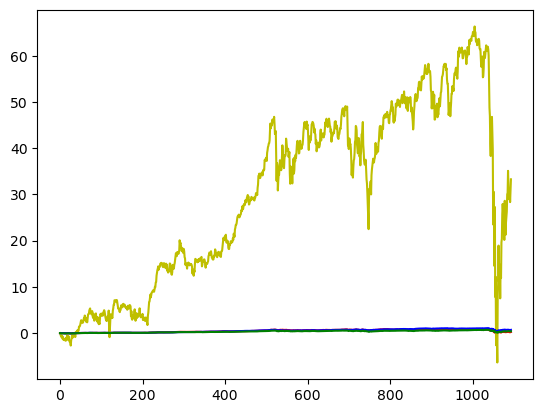

In [ ]:
from data.yahoodownloader import YahooDownloader
baseline_df = YahooDownloader(start_date=DATE_SPLIT['TRADE_START_DATE'], 
                              end_date=DATE_SPLIT['TRADE_END_DATE'], ticker_list=["^DJI"]).fetch_data()
import matplotlib.pyplot as plt
%matplotlib inline
asset_value_a2c = pd.read_csv('results/return_rate_a2c.csv',index_col=0)
asset_value_ppo = pd.read_csv('results/return_rate_ppo.csv',index_col=0)
asset_value_ddpg = pd.read_csv('results/return_rate_ddpg.csv',index_col=0)

plt.plot(asset_value_a2c['0'].values,'r')
plt.plot(asset_value_ppo['0'].values,'y')
plt.plot(asset_value_ddpg['0'].values,'b')
plt.plot(baseline_df.close.values/baseline_df.close[0]-1,'g')